1) Mounting The Data and Importing 
   - Mainly be using keras, OpenCV, sklearn  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()    # Load Kaggle API

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raghuramcs","key":"ef6ab61890d3cef1b02d92945b2daf27"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d grassknoted/asl-alphabet   #API Command

100% 1.02G/1.03G [00:09<00:00, 85.8MB/s]
100% 1.03G/1.03G [00:09<00:00, 116MB/s] 


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('asl-alphabet.zip', 'r')
zip_ref.extractall('files')
zip_ref.close()

In [ ]:
import cv2

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation,Dense,Flatten,BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
 
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline
from sklearn.model_selection import train_test_split

In [ ]:
#datagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
#train_dir = datagen.flow_from_directory('/content/files/asl_alphabet_train/asl_alphabet_train',target_size=(32,32),batch_size=32,subset='training')
#val_dir = datagen.flow_from_directory('/content/files/asl_alphabet_train/asl_alphabet_train',target_size=(32,32),batch_size=32,subset='validation')

Found 78300 images belonging to 29 classes.
Found 8700 images belonging to 29 classes.


2) Data loading and Preprocessing
   - Importing the data from Google Drive and
      - resizing , changing to grayscale
      - giving labels to the image
      - loading the images into arrays and flattening
      - making testing data
      -preprocesssing of image

image_labels =  ['C', 'J', 'P', 'K', 'W', 'D', 'T', 'S', 'M', 'Y', 'Z', 'N', 'space', 'Q', 'U', 'G', 'X', 'O', 'H', 'I', 'R', 'E', 'L', 'nothing', 'V', 'A', 'B', 'del', 'F']
A sample of images from different label 



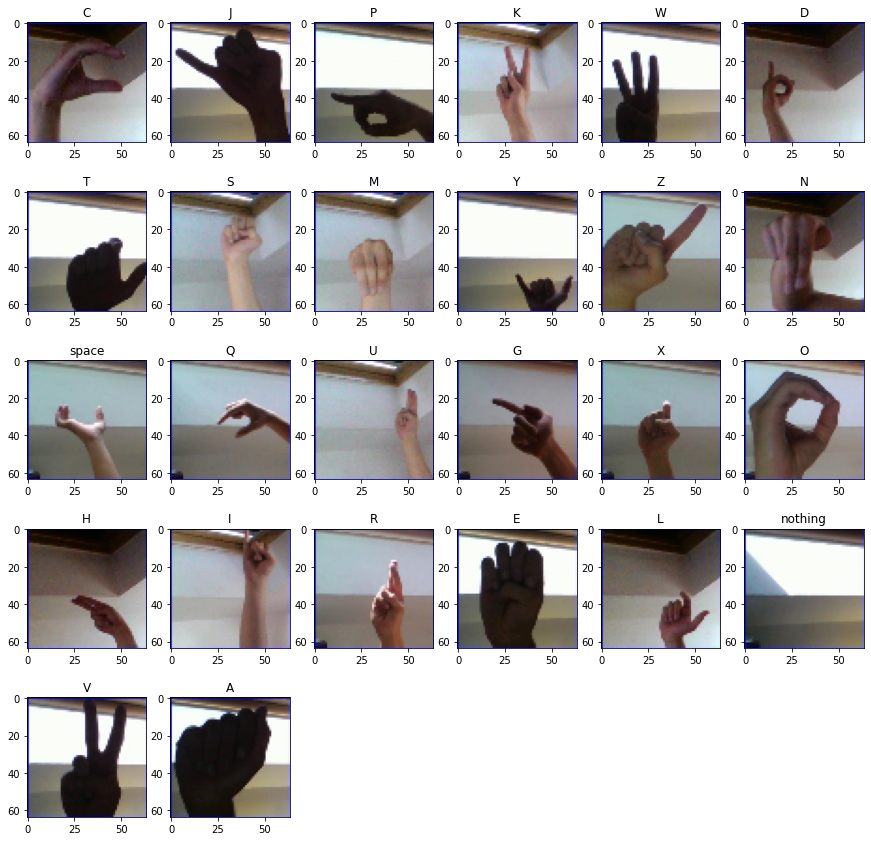

In [ ]:
train_dir = '/content/files/asl_alphabet_train/asl_alphabet_train'

def load_images():
    size_img = 64,64 
    images = []
    labels = []
    for folder in os.listdir(train_dir):
        for file in os.listdir(train_dir + '/' + folder):
            filepath = train_dir + '/' + folder + '/' + file
            image = cv2.imread(filepath)
            final_img = cv2.resize(image, size_img)
            final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
            images.append(final_img)
            labels.append(folder)
            break
    return images, labels

images, labels = load_images()
print("image_labels = ", labels)

fig = plt.figure(figsize = (15,15))
def plot_images(fig, image, label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('on')
    plt.imshow(image)
    plt.title(label)
    return

image_index = 0
row = 5
col = 6
print("A sample of images from different label \n")
for i in range(1,(27)):
    plot_images(fig, images[image_index], labels[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

In [ ]:
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

def load_data():
    """
    Loads data and preprocess. Returns train and test data along with labels.
    """
    images = []
    labels = []
    size = 64,64
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.05)
    
    print()
    print('Loaded', len(x_train),'images for training,','Train data shape =',x_train.shape)
    print('Loaded', len(x_test),'images for testing','Test data shape =',x_test.shape)
    
    return x_train, x_test, y_train, y_test

loading the testing data
  - There are two data sets one with 900 images and another one with 80k images
  - The 80k images takes 3 hrs to load 50% so no 

In [ ]:
x_train, x_test, y_train, y_test = load_data()

LOADING DATA FROM : C | J | P | K | W | D | T | S | M | Y | Z | N | space | Q | U | G | X | O | H | Untitled Folder | I | R | E | L | nothing | V | A | B | del | F | 
Loaded 82650 images for training, Train data shape = (82650, 64, 64, 3)
Loaded 4350 images for testing Test data shape = (4350, 64, 64, 3)


size of the testing data

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(82650, 64, 64, 3)
(82650, 29)
(4350, 64, 64, 3)
(4350, 29)


In [ ]:
#train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_dir, target_size=(64,64), classes=['cat', 'dog'], batch_size=10)
#valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
#test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

IndentationError: ignored

3) Building The model
  - Using the Sequential model from keras
    - Building a Convolutional neural network
      - 6 layers deep (#based on an idea from kaggle)
        - using relu activation
        - 3 * 3 kernel
      - 3 MaxPooling layers
      - Batchnormalization
      - Flatten layer
      - 2 dense layers 
      - splitting validation Data
      

In [ ]:
def create_model():
    
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size = [3,3], padding = 'same', activation = 'relu', input_shape = (64,64,3)))
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(32, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(64, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    model.add(Conv2D(128, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(Conv2D(256, kernel_size = [3,3], padding = 'same', activation = 'relu'))
    model.add(MaxPool2D(pool_size = [3,3]))
    
    
    model.add(BatchNormalization())
    
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation = 'relu',))
    model.add(Dense(29, activation = 'softmax'))
    
    model.compile(optimizer = 'adam', loss = keras.losses.categorical_crossentropy, metrics = ["accuracy"])
    
    print("MODEL CREATED")
    model.summary()
    
    return model

def fit_model():
    model_hist = model.fit(x_train, y_train, batch_size = 25, epochs = 25, validation_split = 0.01)
    return model_hist 

In [ ]:
model = create_model()
model_create = fit_model()

MODEL CREATED
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 7

4) Results
  - 

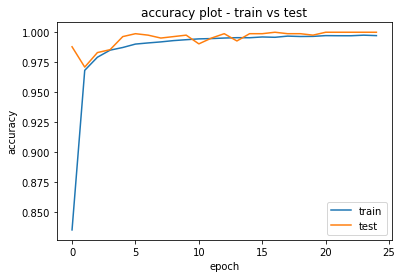

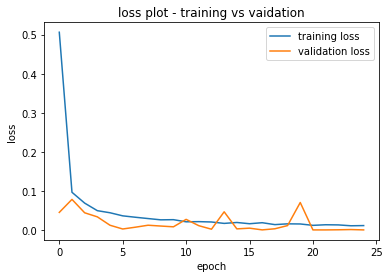

In [ ]:
#accuracy of trainning vs testing data predictions
plt.plot(model_create.history['accuracy'])
plt.plot(model_create.history['val_accuracy'])
plt.legend(['train', 'test'], loc='lower right')
plt.title('accuracy plot - train vs test')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

#accuracy of trainning vs validation data predictions
plt.plot(model_create.history['loss'])
plt.plot(model_create.history['val_loss'])
plt.legend(['training loss', 'validation loss'], loc = 'upper right')
plt.title('loss plot - training vs vaidation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
evaluate_metrics = model.evaluate(x_test, y_test)
print("\nEvaluation Accuracy = ", "{:.2f}%".format(evaluate_metrics[1]*100),"\nEvaluation loss = " ,"{:.6f}".format(evaluate_metrics[0]))

136/136 [==============================] - 1s 6ms/step - loss: 0.0025 - accuracy: 0.9998

Evaluation Accuracy =  99.98% 
Evaluation loss =  0.002461


In [ ]:
test_dir = '/content/drive/My Drive/Projects/ASL_Data/asl_alphabet_test/asl_alphabet_test'
def load_test_data():
    images = []
    names = []
    size = 64,64
    for image in os.listdir(test_dir):
        temp = cv2.imread(test_dir + '/' + image)
        temp = cv2.resize(temp, size)
        images.append(temp)
        names.append(image)
    images = np.array(images)
    images = images.astype('float32')/255.0
    return images, names

test_images, test_img_names = load_test_data()

In [ ]:
def labels_for_plot(predictions):
    predictions_labels = []
    for i in range(len(predictions)):
        for ins in labels_dict:
            if predictions[i] == labels_dict[ins]:
                predictions_labels.append(ins)
                break
    return predictions_labels

predictions_labels_plot = labels_for_plot(predictions)

NameError: ignored

In [ ]:
prev_figure = plt.figure(figsize = (13,13))
def plot_image(fig, image, label, prediction, predictions_label, row, col, index):
    fig.add_subplot(row, col, index)
    plt.axis('off')
    plt.imshow(image)
    title = "prediction : [" + str(predictions_label) + "] "+ "\n" + label
    plt.title(title)
    return

image_index = 0
row = 5
col = 6
for i in range(1,(row*col-1)):
    plot_image(prev_figure, test_images[image_index], test_img_names[image_index], predictions[image_index], predictions_labels_plot[image_index], row, col, i)
    image_index = image_index + 1
plt.show()

NameError: ignored

In [ ]:
predictions =  model.predict(x= prediction_labels, batch = 5, verbose =0)

NameError: ignored

In [ ]:
rounded_predictions =  np.argmax(predictions, )